# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet); MAJ:2019,2024*

**python version >=3.6**

### TP Spectral and temporal modifications , Tancrède Martinez

In [248]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from copy import deepcopy
from math import ceil
import soundfile as sf

from scipy.signal.windows import hann

## Functions

In [249]:
def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return p, x_


def period(x, Fs, Pmin=1 / 300, Pmax=1 / 80, seuil=0.7):
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin * Fs).astype(int)
    Nmax = 1 + np.floor(Pmax * Fs).astype(int)
    Nmax = np.min([Nmax, N])

    _,Nfft = nextpow2(2 * N - 1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I + Nmin
    corr = (rmax / r[0]) * (N / (N - P))
    voiced = corr > seuil
    if not (voiced):
        P = np.round(10e-3 * Fs)

    return P, voiced


## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [250]:
filename = 'aeiou.wav'
file_path = os.path.join(os.getcwd(), filename) 

### **Using Soundfile**

In [251]:
x, Fs= sf.read(file_path)

In [252]:
IPython.display.Audio(file_path)

In [253]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

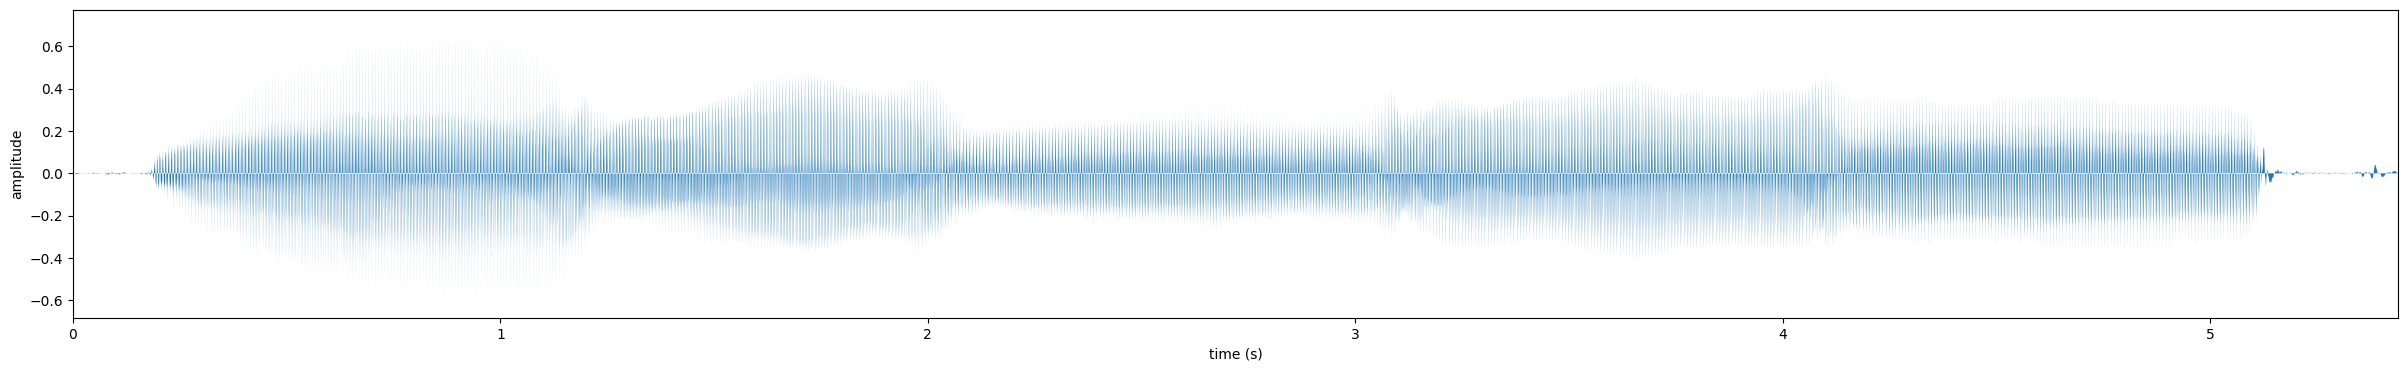

In [254]:
plot_sound(x, times)

In [255]:
sf.write('new_aeiou.wav',x, samplerate=Fs) # to write a new wave file

### 1. Extraction of the analysis mark

In [256]:
def AnalysisPitchMarks(s,Fs):
  A=[[],[],[]]
  t_a=0
  P_a=10**-2 * Fs
  while t_a+2.5*P_a<len(s):
    sample=s[t_a:int(2.5*P_a+t_a)]
    P_a,v_a=period(sample,Fs)
    t_a=int(P_a+t_a)
    A[0].append(t_a)
    A[1].append(v_a)
    A[2].append(P_a)
  A=np.array(A)
  return A


In [257]:
A = AnalysisPitchMarks(x, Fs)
A

array([[  110.,   220.,   330., ..., 59470., 59580., 59690.],
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [  110.,   110.,   110., ...,   110.,   110.,   110.]])

### 2. Synthesis and modification of the temporal and spectral scales

In [258]:
B=np.array([A[0,:],np.arange(len(A[0,:]),dtype=int)])
B

array([[1.100e+02, 2.200e+02, 3.300e+02, ..., 5.947e+04, 5.958e+04,
        5.969e+04],
       [0.000e+00, 1.000e+00, 2.000e+00, ..., 7.020e+02, 7.030e+02,
        7.040e+02]])

2.1 Signal Synthesis


In [259]:
def Synthesis(s,Fs,A,B):
    n= int(B[0,-1])+int(A[2,int(B[1,-1])])
    y=np.zeros(n)
    for k in range(B.shape[1]):
        n_k = int(B[1, k])
        t_a = int(A[0, n_k])
        P_a = int(A[2, n_k])
        x = s[t_a-P_a: t_a+P_a+1]
        hann_window = hann(len(x))
        x = x*hann_window
        t_s = int(B[0, k])
        try:
            y[t_s-P_a: t_s+P_a+1]+=x
        except:
            print(t_s-P_a,t_s+P_a) #y[t_s-P_a: t_s+P_a]+=x[:2*P_a]
    return y

In [260]:
y=Synthesis(x,Fs,A,B)

59580 59800


2.2 Modification of the temporal scale


In [261]:
def ChangeTimeScale(alpha,A,Fs):
    B=[[],[]]
    n_k=0
    t_s=0
    while n_k<len(A[2]):
        B[0].append(int(t_s))
        B[1].append(int(n_k))
        t_s=t_s+A[2,int(n_k)]
        n_k=n_k+1/alpha
    B=np.array(B)
    return B



-110 110
29649 29869


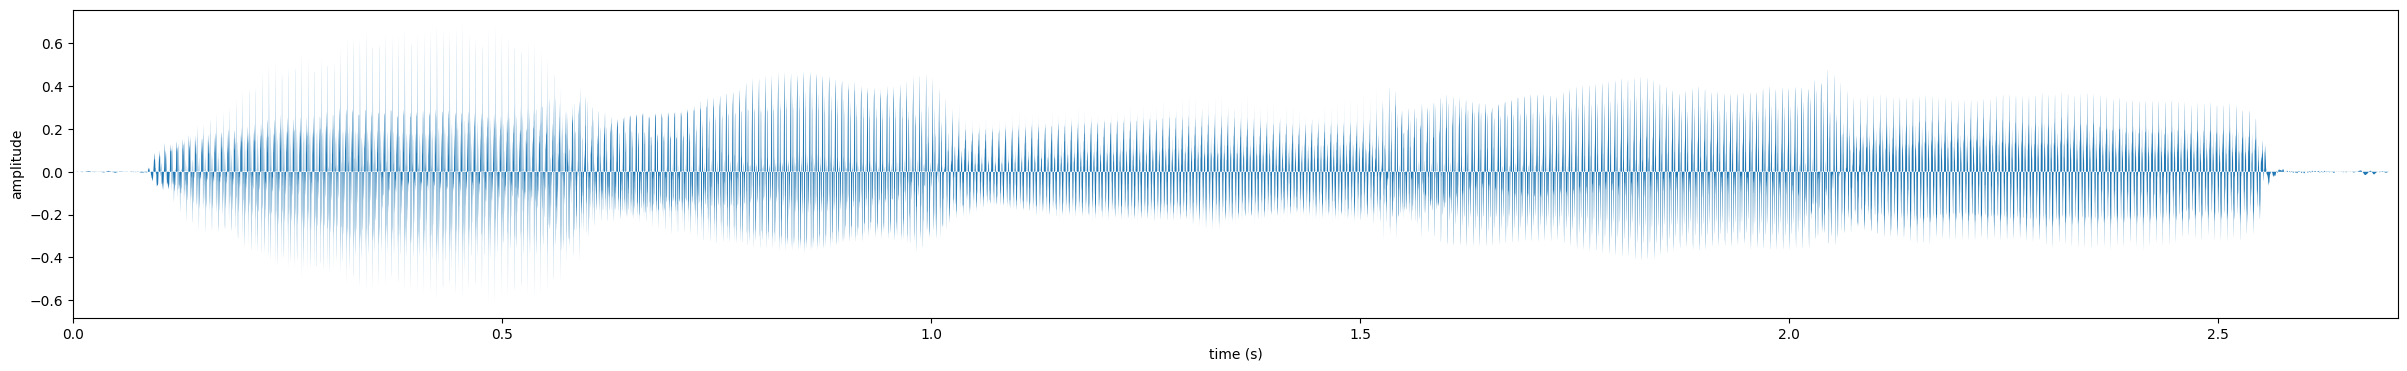

In [262]:
B = ChangeTimeScale(0.5, A, Fs)
y = Synthesis(x, Fs, A, B)
sf.write('aeiou_time_scaled.wav', y,Fs)
IPython.display.Audio('aeiou_time_scaled.wav')
times = np.arange(len(y))*timestep
plot_sound(y, times)

2.3 Modification of the pitch scale

In [263]:
def ChangePitchScale(beta,A,Fs):
    B=[[],[]]
    n_k=0
    t_s=0
    while n_k<len(A[2]):
        B[0].append(int(t_s))
        B[1].append(int(n_k))
        if A[1,int(n_k)]:
            scale_k=1/beta
        else:
            scale_k=1
        t_s=t_s+scale_k*A[2,int(n_k)]
        n_k=n_k+scale_k
    B=np.array(B)
    return B

-110 110
59470 59690


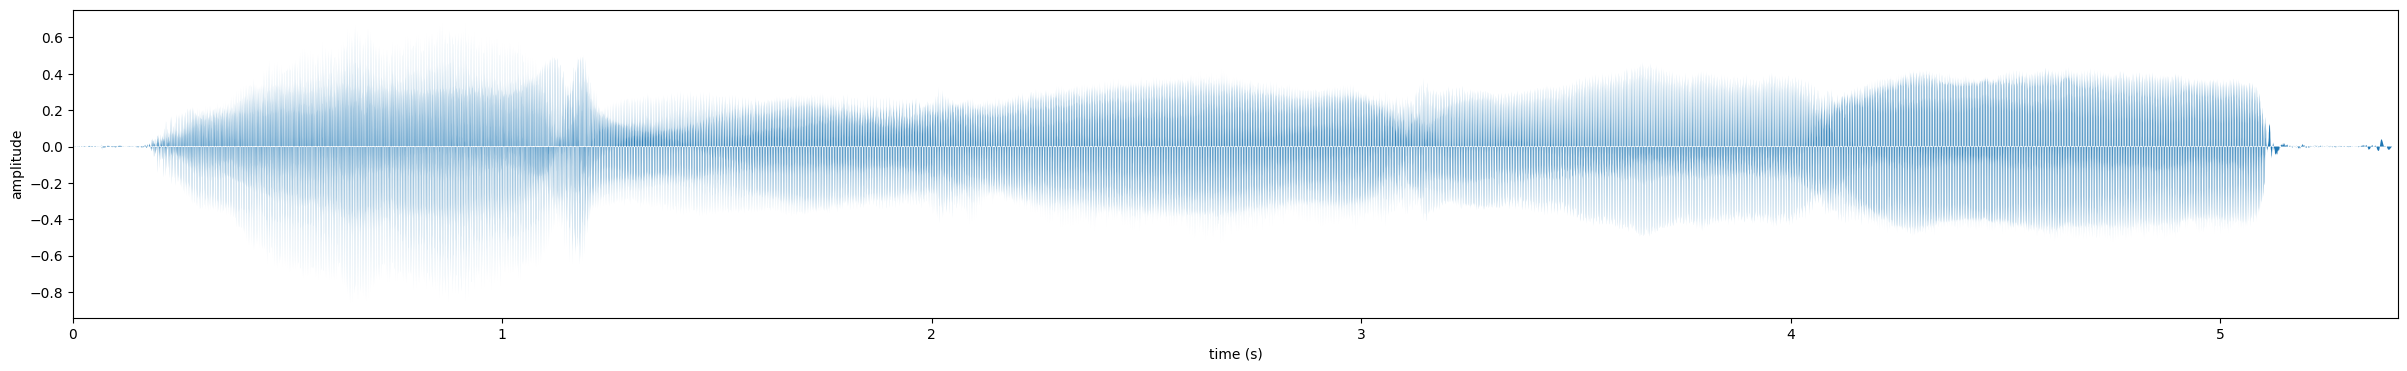

In [264]:
B = ChangePitchScale(2, A, Fs)
y = Synthesis(x, Fs, A, B)
sf.write('aeiou_pitch_scaled.wav', y,Fs)
IPython.display.Audio('aeiou_pitch_scaled.wav')
times = np.arange(len(y))*timestep
plot_sound(y, times)

2.4 Joint modification of the temporal and spectral scales

In [265]:
def ChangeBothScale(alpha,beta,A,Fs):
    B=[[],[]]
    n_k=0
    t_s=0
    while n_k<len(A[2]):
        B[0].append(int(t_s))
        B[1].append(int(n_k))
        if A[1,int(n_k)]:
            scale_k=1/beta
        else:
            scale_k=1
        t_s=t_s+scale_k*A[2,int(n_k)]
        n_k=n_k+scale_k*1/alpha
    B=np.array(B)
    return B

-110 110
119160 119380


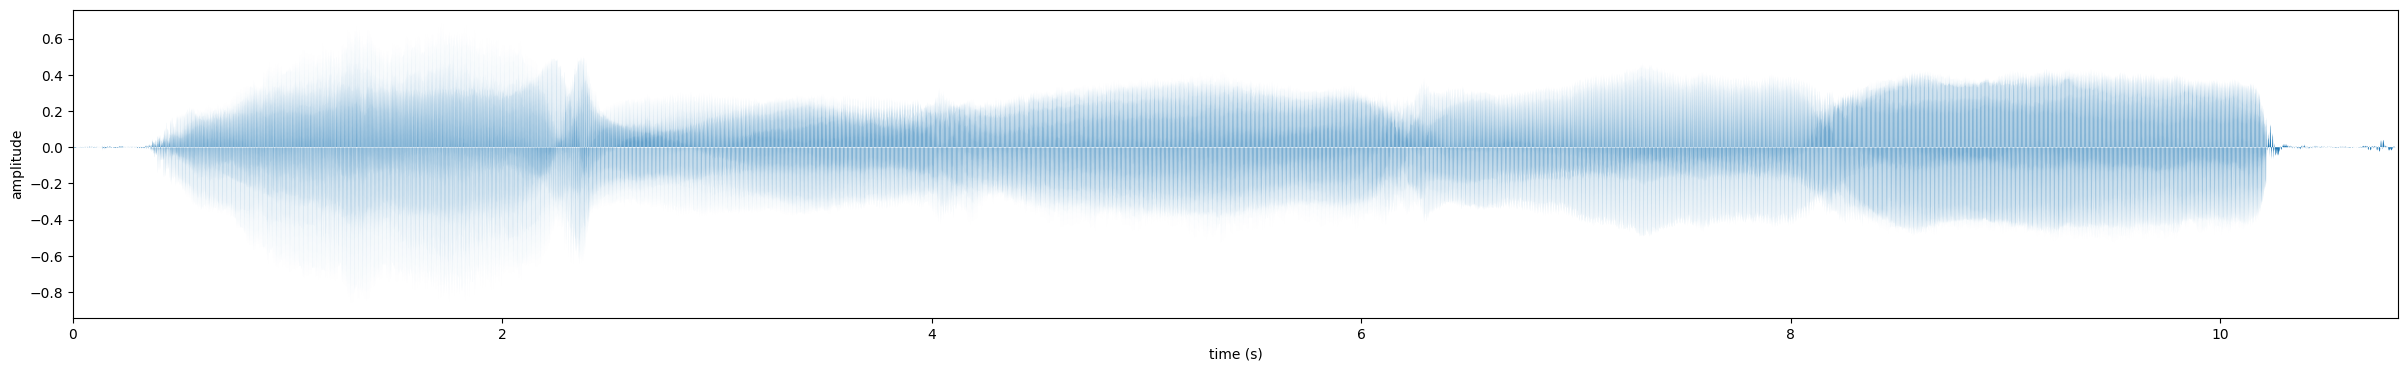

In [266]:
B = ChangeBothScale(2,2, A, Fs)
y = Synthesis(x, Fs, A, B)
sf.write('aeiou_both_scaled.wav', y,Fs)
IPython.display.Audio('aeiou_both_scaled.wav')
times = np.arange(len(y))*timestep
plot_sound(y, times)